In [99]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import statsmodels

In [2]:
df_train = pd.read_csv('../data/custom/df_train.csv')
df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'])

In [15]:
# Splitting the data
split_index = int(len(df_train) * 0.8)
train = df_train.iloc[:split_index]
test = df_train.iloc[split_index:]

# Separating the target variable
X_train = train.drop(['ND_TARGET'], axis=1)
y_train = train['ND_TARGET']
X_test = test.drop(['ND_TARGET'], axis=1)
y_test = test['ND_TARGET']

In [16]:
X_train['year'] = X_train['DATETIME'].dt.year
X_train['month'] = X_train['DATETIME'].dt.month
X_train['day'] = X_train['DATETIME'].dt.day
X_train['hour'] = X_train['DATETIME'].dt.hour
X_train = X_train.drop(['DATETIME'], axis=1)

X_test['year'] = X_test['DATETIME'].dt.year
X_test['month'] = X_test['DATETIME'].dt.month
X_test['day'] = X_test['DATETIME'].dt.day
X_test['hour'] = X_test['DATETIME'].dt.hour
X_test = X_test.drop(['DATETIME'], axis=1)

In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror',
}

In [19]:
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:4507.11759
[1]	Test-rmse:3245.65030
[2]	Test-rmse:2373.63926
[3]	Test-rmse:1768.07043
[4]	Test-rmse:1368.07757
[5]	Test-rmse:1095.72042
[6]	Test-rmse:921.23112
[7]	Test-rmse:814.95090
[8]	Test-rmse:745.04220
[9]	Test-rmse:701.04809
[10]	Test-rmse:672.08920
[11]	Test-rmse:653.06042
[12]	Test-rmse:641.56057
[13]	Test-rmse:628.83580
[14]	Test-rmse:624.23496
[15]	Test-rmse:616.40858
[16]	Test-rmse:614.74832
[17]	Test-rmse:613.63367
[18]	Test-rmse:611.67255
[19]	Test-rmse:607.91665
[20]	Test-rmse:607.09141
[21]	Test-rmse:606.56220
[22]	Test-rmse:603.03146
[23]	Test-rmse:599.94606
[24]	Test-rmse:599.42068
[25]	Test-rmse:599.89605
[26]	Test-rmse:599.77337
[27]	Test-rmse:599.46312
[28]	Test-rmse:596.23165
[29]	Test-rmse:596.43042
[30]	Test-rmse:594.81435
[31]	Test-rmse:592.51305
[32]	Test-rmse:591.53164
[33]	Test-rmse:591.25941
[34]	Test-rmse:590.18407
[35]	Test-rmse:588.08455
[36]	Test-rmse:589.17497
[37]	Test-rmse:587.98191
[38]	Test-rmse:585.15303
[39]	Test-rmse:585.72767
[40]

In [20]:
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 339148.8548441722
R2 Score: 0.9907757789874675


In [21]:
## Grid Search CV
param_grid = {
    'max_depth': [7],
    'min_child_weight': [10],
    'n_estimators': [550],
    'colsample_bytree': [1.0],
    'learning_rate': [0.08]
}

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
xgb_reg = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'learning_rate': [0.08],
                         'max_depth': [7], 'min_child_weight': [10],
                         'n_estimators': [550]},
             scoring='neg_mean_squared_error', verbose=1)

In [25]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.08, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 550}
Best score: 408277.1981523767


In [26]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [27]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 290220.8383213791
R2 Score: 0.9921065304603524


In [49]:
filename = 'XGB_grid.sav'
pickle.dump(best_model, open('models_sav/' + filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('models_sav' + filename, 'rb'))

In [28]:
df_train = pd.read_csv('../data/custom/df_train.csv')
df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'])

X = df_train.drop(['ND_TARGET'], axis=1)
y = df_train['ND_TARGET']

X['year'] = X['DATETIME'].dt.year
X['month'] = X['DATETIME'].dt.month
X['day'] = X['DATETIME'].dt.day
X['hour'] = X['DATETIME'].dt.hour
X = X.drop(['DATETIME'], axis=1)

# Generate predictions
y_pred = best_model.predict(X)

In [29]:
results = pd.DataFrame({
    'DATETIME': df_train['DATETIME'],
    'Actual': y,
    'Predicted': y_pred
})

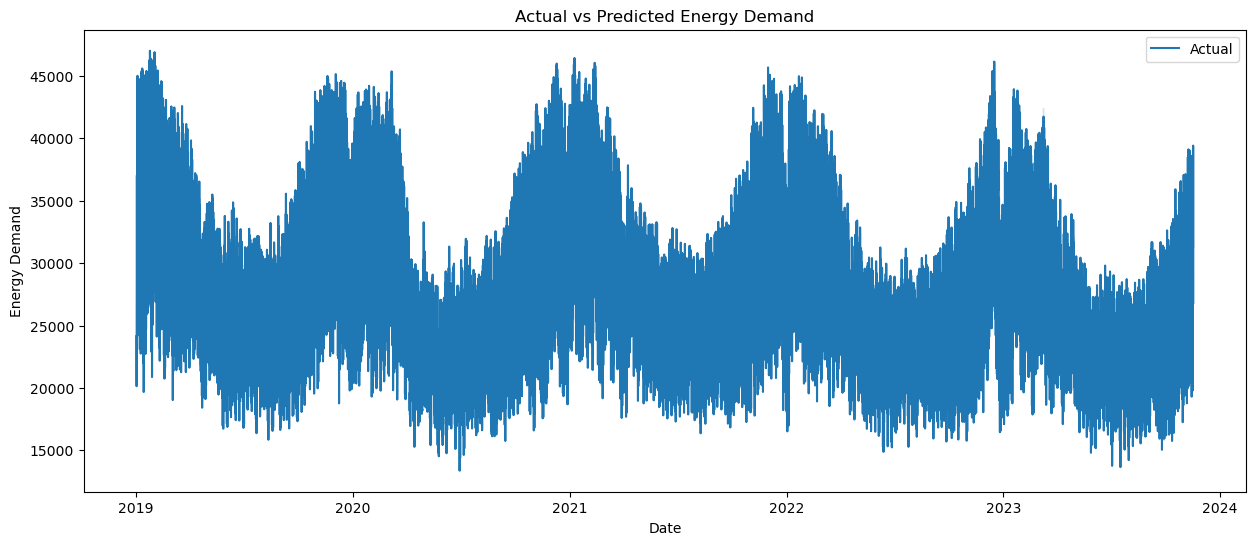

In [30]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='DATETIME', y='Actual', data=results, label='Actual')
# sns.lineplot(x='DATETIME', y='Predicted', data=results, label='Predicted')
plt.title('Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend() 
plt.show()

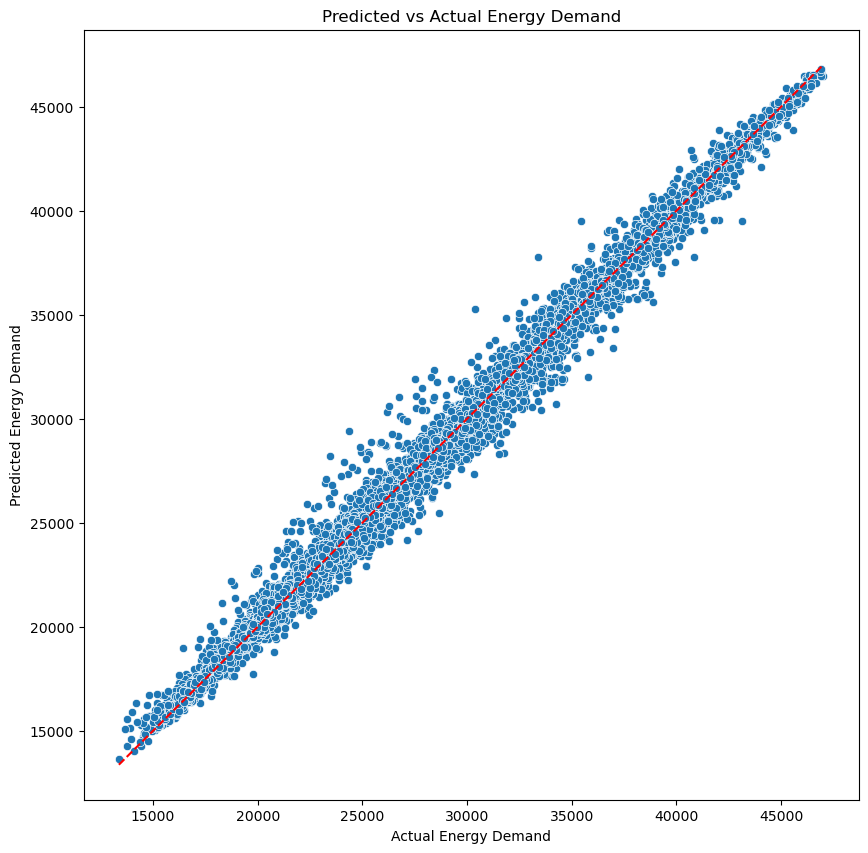

In [72]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.title('Predicted vs Actual Energy Demand')
plt.xlabel('Actual Energy Demand')
plt.ylabel('Predicted Energy Demand')
plt.plot([results['Actual'].min(), results['Actual'].max()], 
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', linestyle='--') # Diagonal line for reference
plt.show()

# Time Series Models

In [3]:
df_train = pd.read_csv('../data/custom/df_train.csv')
df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'])
df_train.set_index('DATETIME', inplace=True)
df_daily = df_train[['ND_TARGET']].resample('D').sum()

In [4]:
df_daily

,ND_TARGET
DATETIME,
2019-01-02,664567
2019-01-03,844405
2019-01-04,896046
2019-01-05,896681
2019-01-06,823999
...,...
2023-11-12,666835
2023-11-13,700332
2023-11-14,676409


Let's start with decomposing our time series:

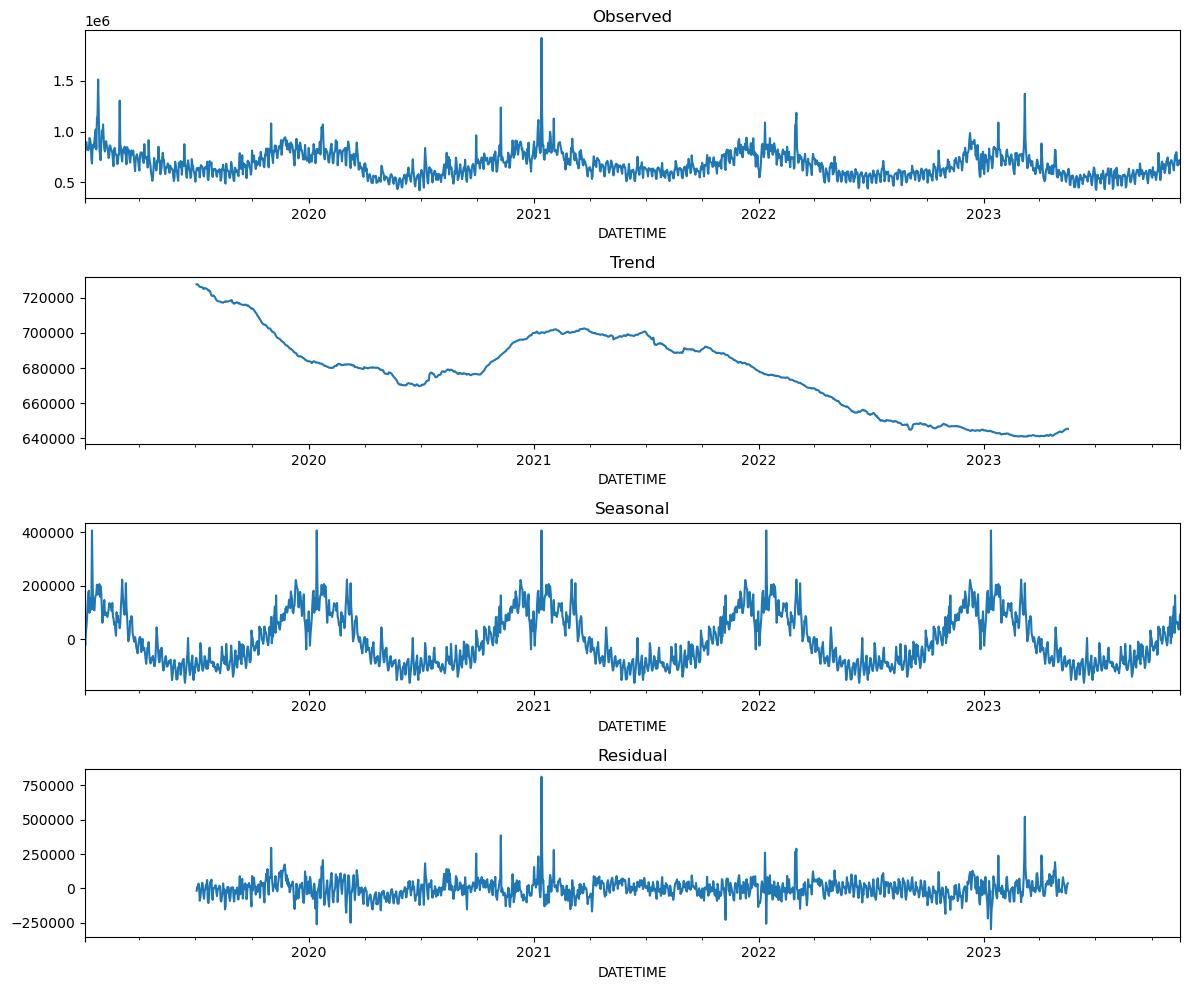

In [8]:
decomposition_daily = seasonal_decompose(df_daily, model='additive', period=365)

# Plotting the decomposed components for the daily data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition_daily.observed.plot(ax=ax1, title='Observed')
decomposition_daily.trend.plot(ax=ax2, title='Trend')
decomposition_daily.seasonal.plot(ax=ax3, title='Seasonal')
decomposition_daily.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

Our time series is decomposed into trend, seasonal, and the remaining residual (noise).

Within the trend, we see a slightly decrease from 2020 to 2023, suggesting that the overall energy demand has a slight downward trajectory

The seasonality plot shows consistent peaks and troughs each year, which likely correspond to seasonal changes in energy demand, such as higher demand in winter for heating.

The residual part represents the irregular part, or noise, of the data.

In [20]:
# ADF-Test to determine stationarity
adf_result = adfuller(df_daily)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.632247
p-value: 0.005174
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


The Augmented Dickey-Fuller test tests the null hypothesis, that the time series has a unit root (isn't stationary). 

The ADF Statistic is -3.632, which shows evidence against the null hypothesis. Additionally, the p-value of 0.00517 shows a high significance (<0.05), so the null hypothesis can be rejected. Therefore, the data is shows stationarity.
The confidence intervals of 10%, 5% and 1% show that the Null-hypothesis can be rejected with a confidence level of more than 95%.

The test implies that our data should be suitable for time series models that assume stationarity.

c:\Users\Sören Schlißke\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


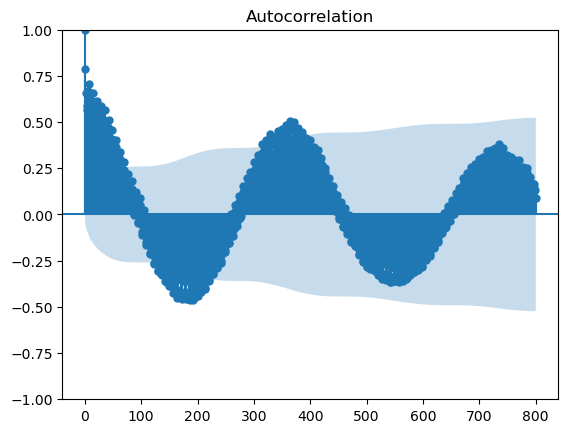

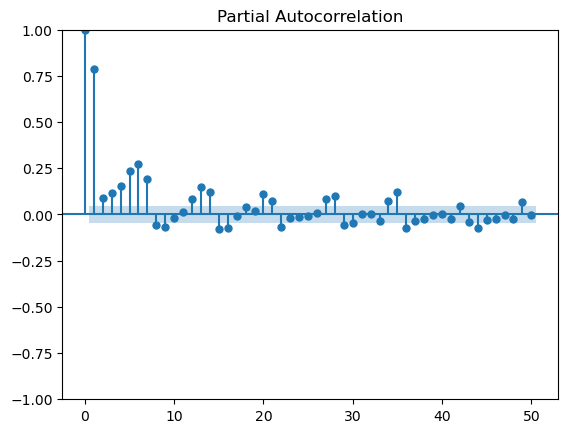

In [21]:
plot_acf(df_daily, lags=800)
plot_pacf(df_daily, lags=50);

Autocorrelation and partial autocorrelation show how the current values are related to past values. 

The autocorrelation plot shows a strong yearly seasonality within the data. This is likely due to higher energy demand in winter due to colder temperatures. As the lag increases, the seasonal effect gets smaller, which is typical for seasonal patterns.

The partial autocorrelation measures the correlation between the series and its lags that is not explained by correlations at all lower-order lags. In the PAC-plot, there is a very high peak at the first lag, which becomes insignificant after a few lags.

This implicates that we should use a model that accounts for seasonality (given the AC-plot) and autoregressive elements (given the PAC-plot). Therefore, we start with an ARIMA model.

In [78]:
arima_model = pm.auto_arima(df_daily, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52909.803, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51652.392, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=45193.724, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=44946.398, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=44927.027, Time=0.96 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=44896.293, Time=1.33 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=44853.922, Time=1.32 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=17.29 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=44864.735, Time=5.80 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=44902.986, T

In [80]:
best_model_arima = ARIMA(df_daily, order=(5,0,1))
best_model_arima = best_model_arima.fit()
predictions = best_model_arima.predict(start=0, end=len(df_daily)-1)
mse_arima = mean_squared_error(df_daily, predictions, squared=False)
aic_arima = best_model_arima.aic

print(f'RMSE: {round(mse_arima, 3)}')
print(f'AIC: {round(aic_arima, 3)}')

RMSE: 70915.185
AIC: 44835.107


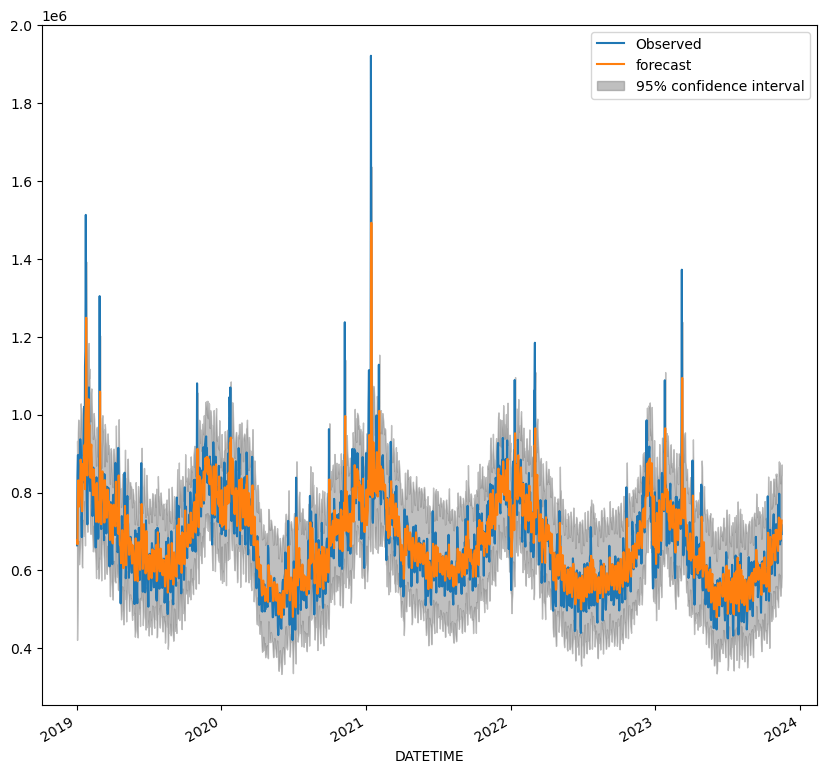

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(df_daily, label='Observed')
plot_predict(best_model_arima, start=0, end=len(df_daily)-1, ax=ax)
ax.legend()
plt.show()

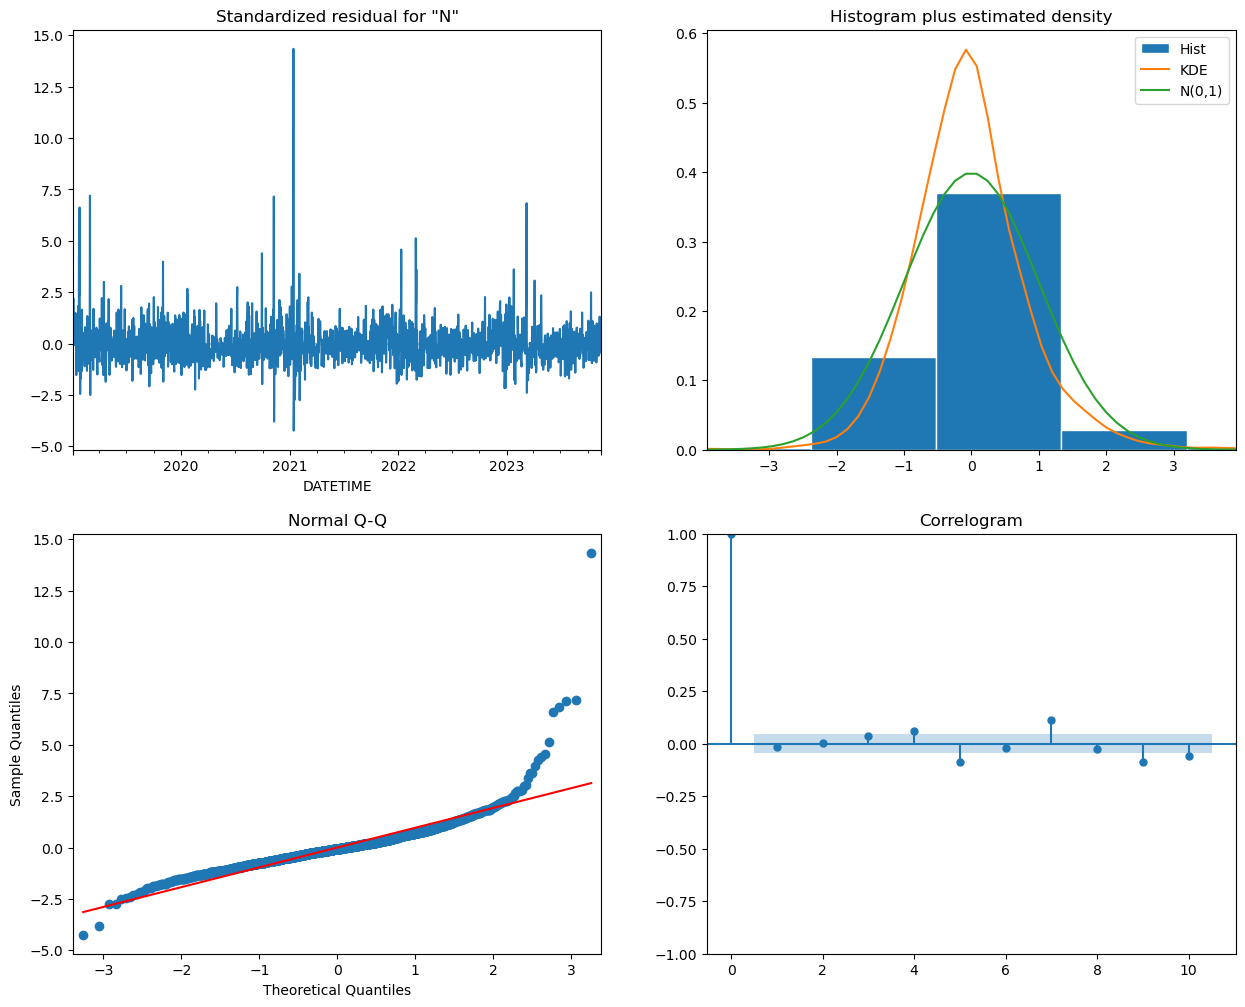

In [83]:
best_model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [87]:
df_train = pd.read_csv('../data/custom/df_train.csv')
df_train['DATETIME'] = pd.to_datetime(df_train['DATETIME'])
df_train.set_index('DATETIME', inplace=True)
df_daily = df_train[['ND_TARGET']].resample('D').sum()

exog_columns = df_train.columns.difference(['ND_TARGET'])
df_daily_exog = df_train[exog_columns].resample('D').mean()

In [39]:
stl = STL(df_daily, seasonal=365)
res = stl.fit()

seasonal = res.seasonal
trend = res.trend
residual = res.resid

# Differencing the seasonal component
diff_seasonal = seasonal.diff(365).dropna()

# Test if the seasonal component is stationary
adf_test = adfuller(diff_seasonal)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -12.477597249085449
p-value: 3.143022705383011e-23


In [88]:
# Fit SARIMA on the residual component
residual_model = SARIMAX(residual, order=(5, 0, 1), seasonal_order=(0, 0, 0, 0), exog=df_daily_exog)  # No seasonal component here
residual_model = residual_model.fit()

c:\Users\Sören Schlißke\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [89]:
# Add the trend and seasonal component back to the predictions
predictions = residual_model.predict(start=0, end=len(residual)-1) + trend + seasonal

# Calculate metrics
mse = mean_squared_error(df_daily, predictions, squared=False)
r2 = r2_score(df_daily, predictions)
aic = residual_model.aic
print(f'RMSE: {round(mse, 3)}')
print(f'R2: {round(r2, 3)}')
print(f'AIC: {round(aic, 3)}')

RMSE: 41594.241
R2: 0.891
AIC: 42998.702


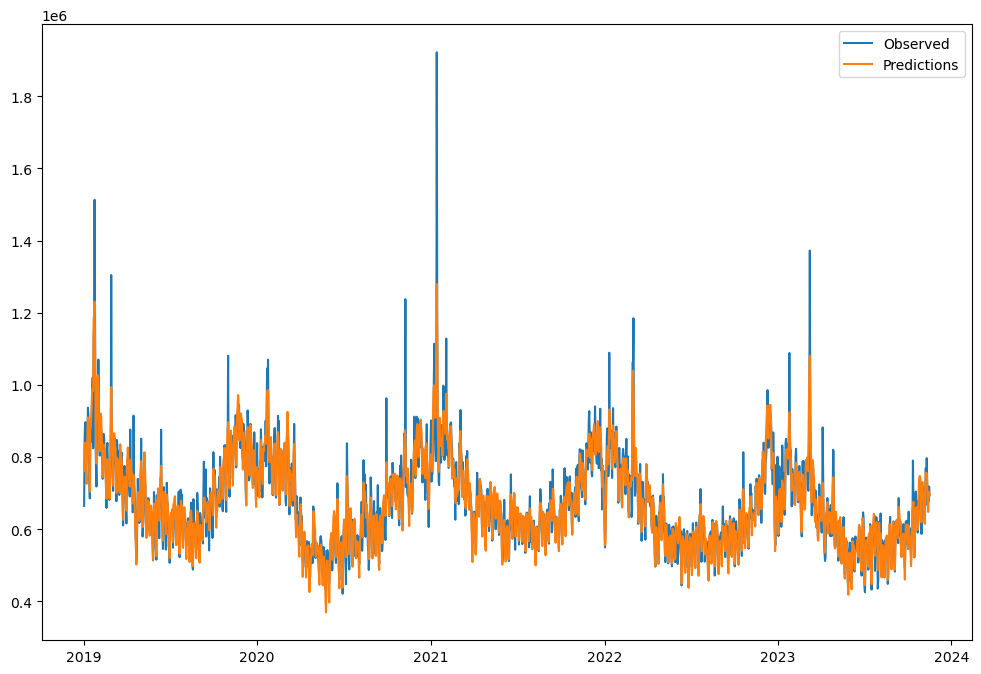

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_daily, label='Observed')
ax.plot(predictions, label='Predictions')
# plot_predict(, start=0, end=len(df_daily)-1, ax=ax)
ax.legend()
plt.show()

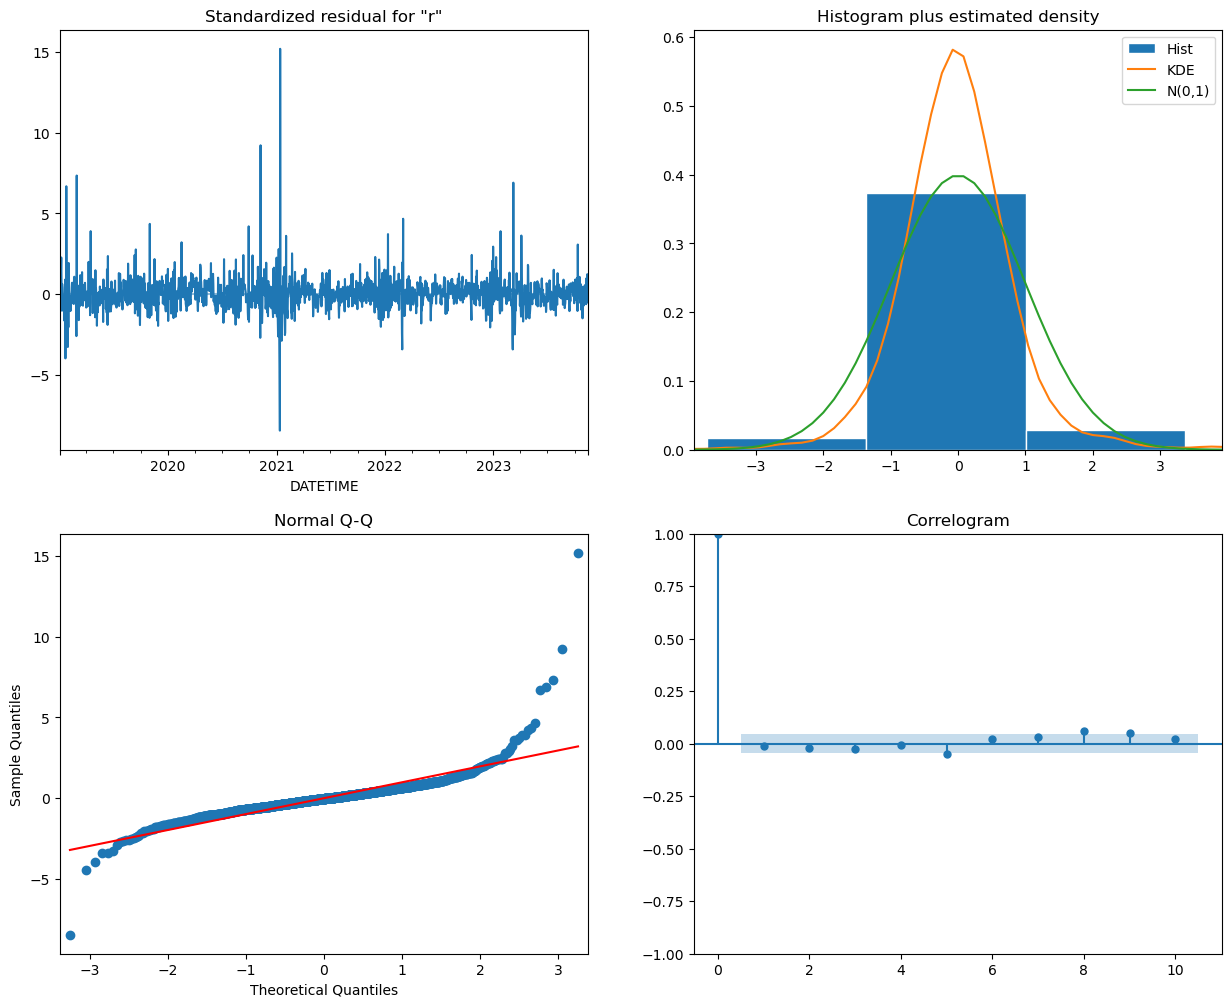

In [91]:
residual_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Out of sample predictions:

In [96]:
# Residual prediction with SARIMAX
residual_model = SARIMAX(residual, order=(5, 0, 1), seasonal_order=(0, 0, 0, 0)) 
residual_model = residual_model.fit()

# Exponential Smoothing for trend prediction
trend_model = ExponentialSmoothing(trend, trend='add', seasonal=None, damped_trend=True)
trend_model = trend_model.fit(smoothing_level=0.6, smoothing_trend=0.02, damping_trend=1)

# Forecast the trend component out-of-sample
trend_forecast = trend_model.predict(start=len(df_daily), end=len(df_daily) + 30)

# Extend the seasonal component by repeating the last year's seasonality
seasonal_forecast = np.tile(seasonal[-31:], 1)
seasonal_forecast = seasonal_forecast[:31]

# Forecast the residuals out-of-sample
residual_forecast = residual_model.get_forecast(steps=31, exog=df_daily_exog).predicted_mean

# Combine the forecast components
combined_forecast = trend_forecast.values + seasonal_forecast + residual_forecast

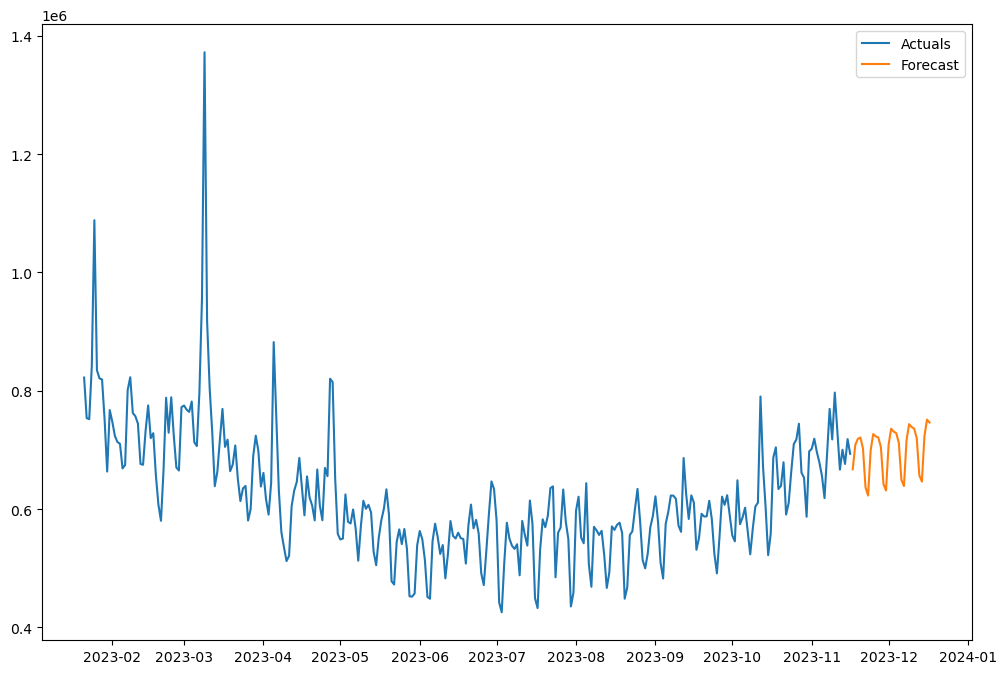

In [97]:
fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(trend, label='Trend')
# ax.plot(trend_forecast, label='Trend')
# ax.plot(seasonal_forecast, label='Seasonal')
# ax.plot(residual_forecast, label='Residuals')
ax.plot(df_daily.tail(300), label='Actuals')
ax.plot(combined_forecast, label='Forecast')
ax.legend()
plt.show()